# DataLoading

In [1]:
import src.DataLoading

In [2]:
leg = src.DataLoading.LegislatureEnum.XVI
legislature_data = src.DataLoading.get_all_legislature_data(leg, force_download=False)



In [3]:
import pandas as pd

vote_df = pd.DataFrame.from_records([
    {'scrutin.uid': int(v.scrutin.numero)
     , 'scrutin.dateScrutin': v.scrutin.date
     , 'groupe_acronyme': v.parlementaire_groupe_acronyme
     , 'parlementaire_slug': v.parlementaire_slug
     , 'vote': v.position.value } for v in legislature_data.votes])

In [4]:

groupes_df = pd.DataFrame.from_records([
    {'groupe_slug': g.slug
    , 'groupe_acronyme': g.acronyme
    , 'Groupe': tuple(int(c)/ 255 for c in g.couleur.split(',')) if len(g.couleur.split(',')) == 3 else (0.5, 0.5, 0.5)
    , 'Nom Groupe': g.nom
    }
    for g in legislature_data.groupes])


In [5]:
deputes_df = pd.DataFrame.from_records([
    {'id': int(d.id)
    , 'Nom Parlementaire': d.nom
    , 'groupe_sigle': d.groupe_sigle
    , 'parlementaire_slug': d.slug
    }
    for d in legislature_data.deputes
])


In [6]:
full_df = vote_df.merge(deputes_df, on='parlementaire_slug', how='left').merge(groupes_df, left_on='groupe_sigle', right_on='groupe_acronyme', how = 'left')

In [49]:
import numpy as np
vote_matrix = full_df.pivot_table(index='scrutin.uid', columns=['parlementaire_slug', 'Groupe', 'Nom Groupe'],values=['vote']).replace({np.nan:0})
vote_matrix = vote_matrix.T.reset_index("Groupe",drop=False)
vote_matrix = vote_matrix.reset_index('Nom Groupe',drop=False)
couleurs = vote_matrix.pop("Groupe").droplevel(0)
nom_groupe = vote_matrix.pop("Nom Groupe").droplevel(0)
vote_matrix = vote_matrix.T.droplevel(0, axis='columns')
vote_matrix.index.name = 'Numero Scrutin'

In [ ]:
from matplotlib.colors import to_hex

slug_to_name_map = deputes_df.set_index('parlementaire_slug')['Nom Parlementaire']
groupes_map = groupes_df.set_index('Nom Groupe')['Groupe'].apply(to_hex).to_dict()


# Analyse

### Heatmap des votes par parlementaire et par scrutin pendant la XVIeme législature

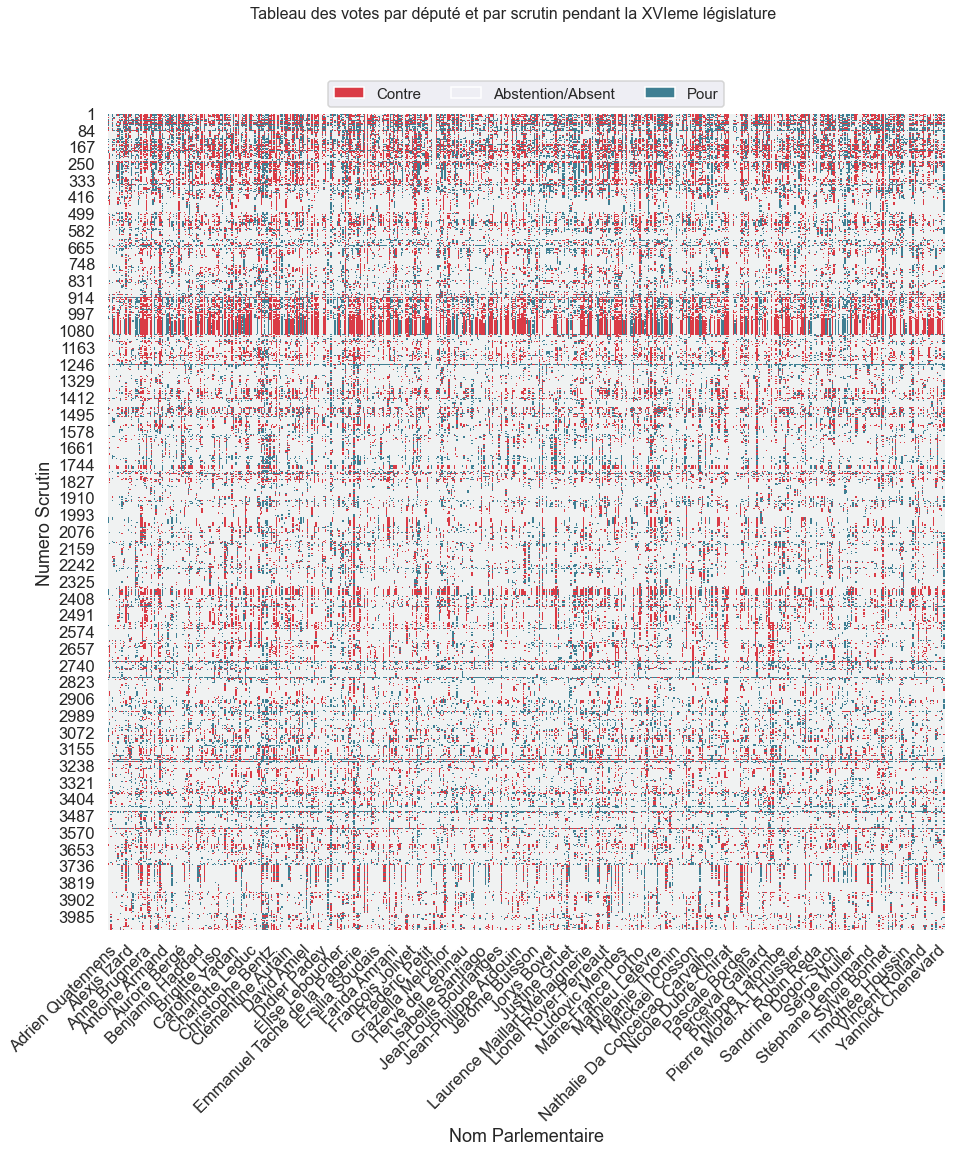

In [165]:
import seaborn as sns
sns.set("talk")
sns.set_style("dark")
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (15,15))
cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(vote_matrix
            ,cmap=cmap
            ,cbar=False
            ,ax=ax)

x_labels = [slug_to_name_map[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(x_labels)
ax.set_xlabel('Nom Parlementaire');

fig.suptitle("Tableau des votes par député et par scrutin pendant la XVIeme législature", fontsize=16)

vote_legend_handles = [Patch(facecolor=cmap.get_under()), Patch(facecolor=cmap.get_bad()) , Patch(facecolor=cmap.get_over()) ]
vote_legend_labels = ["Contre", "Abstention/Absent", "Pour"]
ax.legend(vote_legend_handles, vote_legend_labels,  ncols=3
                ,fontsize = 'small'
                ,loc='lower center'
                ,bbox_to_anchor = (0.5 , 1))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor");

De loin on observe peu de structure par colonne (parlementaire), mais regardons de plus près.


### Regroupement des parlementaires par leur votes
Si on defini une distance entre parlementaires comme la similarité de leur votes (leur correlation par example), on peut organiser les députés en clusters \(en utilisant la [methode de wards](https://en.wikipedia.org/wiki/Ward%27s_method) par example\).

In [185]:
def adds_linebreaks_to_labels(labels, max_char_length=10):
    return_labels = []
    for label in labels:
        try:
            splits = label.split(" ")
        except AttributeError:
            return_labels.append(label)
            continue
        return_splits = []
        current_len = 0
        for split in splits:
            if current_len + len(split) > max_char_length:
                return_splits.append("\n")
                return_splits.append(split)
                current_len=len(split)
            else:
                return_splits.append(" ")
                return_splits.append(split)
                current_len+=len(split)
        return_labels.append("".join(return_splits).strip())
    return return_labels



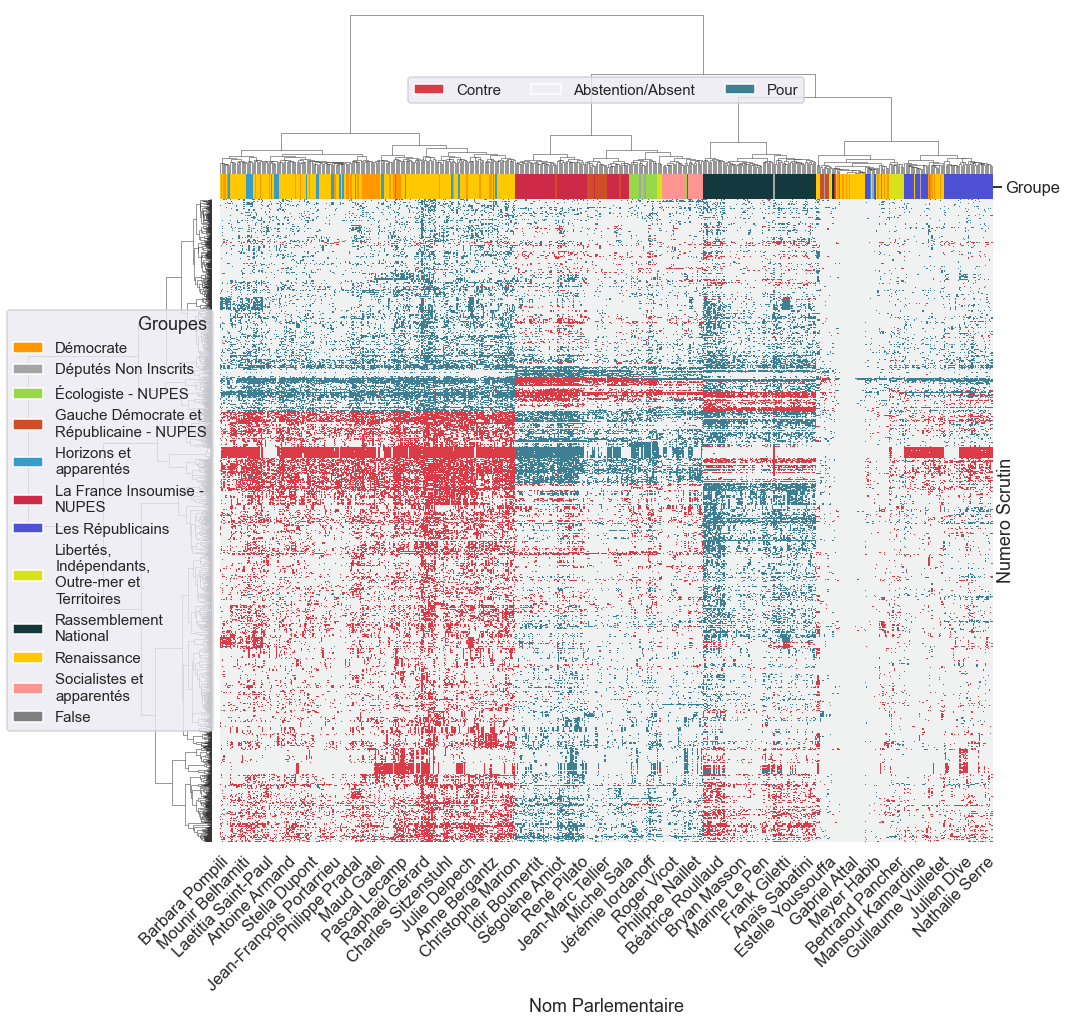

In [189]:
from matplotlib.patches import Patch
import seaborn as sns


cmap = sns.diverging_palette(10, 220, as_cmap=True)
ax = sns.clustermap(vote_matrix
                    ,row_cluster=True
                    ,figsize=(15,15)
                    ,cmap=cmap
                    ,cbar_pos=None
                    ,method='ward'
                    ,col_colors=couleurs
                    ,**{"xticklabels":"auto", "yticklabels":False})


vote_legend_handles = [Patch(facecolor=cmap.get_under()), Patch(facecolor=cmap.get_bad()) , Patch(facecolor=cmap.get_over())]
vote_legend_labels = ["Contre", "Abstention/Absent", "Pour"]
ax.ax_col_dendrogram.legend(vote_legend_handles, adds_linebreaks_to_labels(vote_legend_labels),  ncols=3
                ,fontsize = 'small'
                ,loc='center'
                ,bbox_to_anchor = (0.5 , 0.5))


group_legend_handles = [Patch(facecolor=groupes_map[name]) for name in groupes_map]
group_legend_labels = groupes_map.keys()
ax.ax_row_dendrogram.legend(group_legend_handles, adds_linebreaks_to_labels(group_legend_labels, 18), title='Groupes'
                ,fontsize = 'small'
                ,loc='center left'
                ,bbox_to_anchor = (-0.1 , 0.5)
                ,alignment = 'right')

x_labels = [slug_to_name_map[item.get_text()] for item in ax.ax_heatmap.get_xticklabels()]
ax.ax_heatmap.set_xticklabels(x_labels)
ax.ax_heatmap.set_xlabel('Nom Parlementaire')
plt.setp(ax.ax_heatmap.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor");

On voit bien plus clair, on remarque bien 3 ou 4 clusters importants, qui ont tendance a voter de facon très similaires.
Nous avons ajouté la couleur politique de leur groupe parlementaire pour référence, et on remarque a quel point celle-ci explique le clustering.

## Réduction de la dimension
On a vu juste au dessus qu'il ne fallait qu'une paire d'information sur un parlementaire pour expliquer son vote. Du coup, nous pouvons réduire la dimension de l'espace de ~4000 (nombre de scrutins), à juste 2

### Analyse en composantes principales

In [90]:
from sklearn.decomposition import PCA
n_components = 30
pca_decomp = PCA(n_components=n_components)
transform = pca_decomp.fit_transform(vote_matrix.T)

In [91]:
explained_variance_df = pd.DataFrame(data = np.array([np.arange(0, n_components) + 1, pca_decomp.explained_variance_ratio_.cumsum()]).T, columns = ["N Composante Principale", "Variance Expliquée Cumulative"])


<Axes: xlabel='N Composante Principale', ylabel='Variance Expliquée Cumulative'>

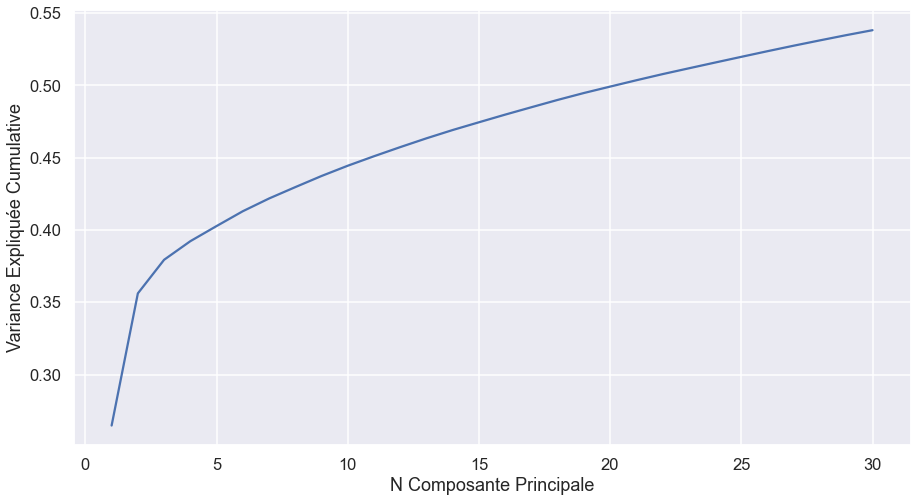

In [110]:
sns.set("talk")

fig, ax = plt.subplots(figsize = (15,8))

sns.lineplot(data = explained_variance_df, x="N Composante Principale", y = "Variance Expliquée Cumulative", ax =ax)

La figure ci-dessus montre que ne connaitre que 2 chiffres sur un député, explique près de 35% de toute la variance associée a tous ses votes.

On peut maintenant montrer la dispersion des représentations tronquées aux deux premières composantes.

Les deux axes n'ont pas de dimensions, meme si on peut trouver une interpretation a posteriori.

In [102]:
comp_df = pd.DataFrame(transform[:, :3], columns=['1ere Composante', '2eme Composante', '3eme Composante'])
comp_df['Nom Parlementaire'] = nom_groupe.index
comp_df['Nom Groupe'] = nom_groupe.values
comp_df['Couleur Groupe'] = comp_df['Nom Groupe'].map(groupes_map)

In [ ]:
sns.set

<Axes: xlabel='1ere Composante', ylabel='2eme Composante'>

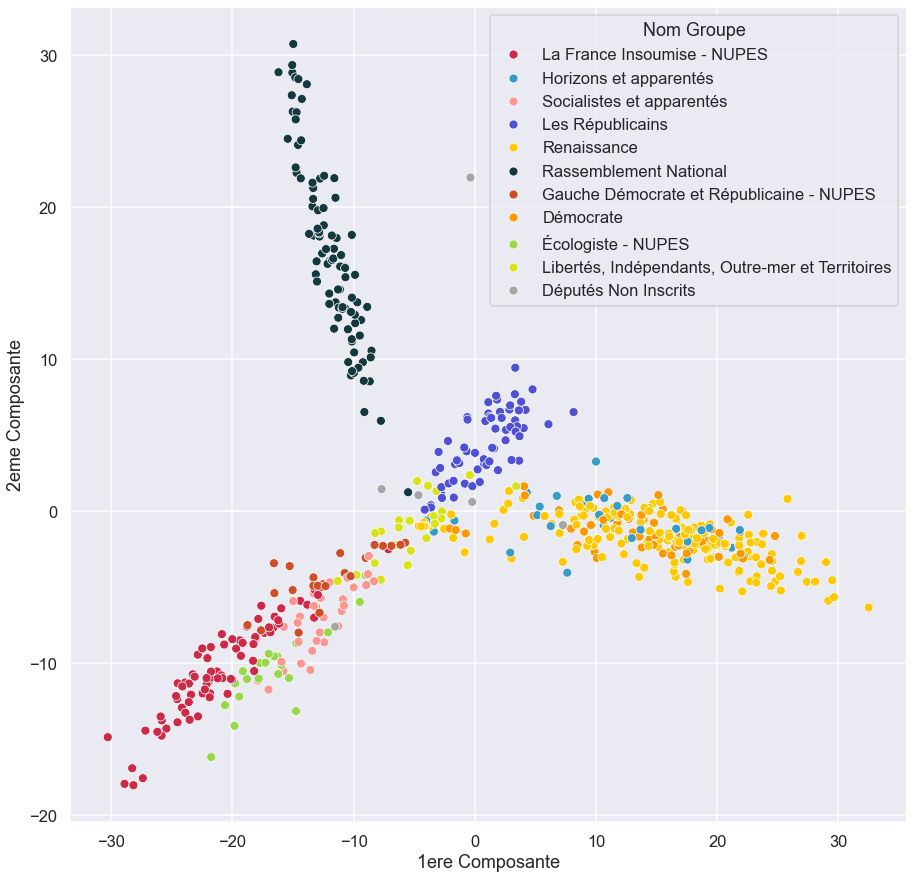

In [109]:
sns.set('talk')
fig, ax = plt.subplots(figsize = (15,15))
sns.scatterplot(data = comp_df, x='1ere Composante', y = '2eme Composante', hue = 'Nom Groupe', palette=groupes_map, ax = ax)

En superposant la couleur des groupes politiques, on peut également avoir une idée de la distance entre groupes parlementaires.